## Goal  ⛳️

* Use bayesian model to forecast daily sales and estimate the posterior interval

### Why bayesian model?

* In this competition we can utilize a lot of historical data (prior); and by updating the prior belief we can make a forecast (which is the posterior)
* Bayesian model allows to estimate posterior predictive interval on parameters and response variables

### Limitation

* Here we only modeled the total sale and its uncertainty
* To make the full prediction we need to scale it up to full hierarchies (aggregated by state, by store, by department etc)
* There can be more features/dimensions
* Needs a lot of experimentation on initializing the paramter, due to the overdispersion

### Referenced Notebook

https://www.kaggle.com/allunia/m5-uncertainty


## Problem formulation

We considered the sale of products is a poisson process, i.e, increasing exposing variable (days of operating) in this case, the rate of daily product sale is $\lambda$


$$ y | \beta, X_i \sim indep. Poisson(\lambda_{i})$$
where $$  \lambda = rt$$

$$ log(\lambda) \sim log(t) + log(r) $$
where $$r = \beta_{i}X $$

here we call log(t) offset, and ideally X doesn't include information on exposure variable (t)


✈️*please upvote if you like it* 🚀

## Import Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from  datetime import datetime, timedelta
import gc
import numpy as np
#plt.style.use('ggplot')

In [2]:
%matplotlib inline
import sys
import re

plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

plt.rcParams['figure.figsize'] = 14, 6
np.random.seed(0)
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [3]:
#os.listdir('../m5-forecasting-uncertainty/')

In [4]:
submission = pd.read_csv('../input/m5-forecasting-uncertainty/sample_submission.csv')

In [5]:
#submission.shape

In [6]:
#submission.head()

In [7]:
sale = pd.read_csv('../input/m5-forecasting-uncertainty/sales_train_validation.csv')

In [8]:
#sale.head()

In [9]:
sale.shape

(30490, 1919)

In [10]:
total_historical = sale.iloc[:,6:].sum()

In [11]:
total_historical.shape

(1913,)

In [12]:
calendar = pd.read_csv('../input/m5-forecasting-uncertainty/calendar.csv')

In [13]:
calendar['event_true_1'] = calendar.event_name_1.notna()
calendar['event_true_2'] = calendar.event_name_2.notna()

calendar['event_true_all'] = calendar.event_true_1 + calendar.event_true_2
calendar['event_true_all'] = calendar.event_true_all.apply(lambda x: x>0)
calendar['event_true_all'] = calendar.event_true_all.astype('int')
calendar['date'] = pd.to_datetime(calendar.date)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [14]:
#calendar.dtypes

In [15]:
#calendar.columns

In [16]:
calendar['d_parse'] = calendar.d.apply(lambda x: int(x.split('_')[1]))

In [17]:
#calendar.head()

In [18]:
calendar_feature = calendar[['wm_yr_wk', 'wday', 'month', 'year', \
       'snap_CA', 'snap_TX', 'snap_WI', \
       'event_true_all', 'd_parse']]

In [19]:
calendar_feature.dtypes

wm_yr_wk          int64
wday              int64
month             int64
year              int64
snap_CA           int64
snap_TX           int64
snap_WI           int64
event_true_all    int64
d_parse           int64
dtype: object

## Build Bayesian model in Pymc3

In [20]:
# specify formula
fml = 'total ~ wday + month + year + snap_CA + snap_TX + snap_WI + event_true_all + d_parse'

#### Standardize data
To help with model convergence, it is better to standardardize your data first

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
scaler = StandardScaler()
#minmax = MinMaxScaler()

In [22]:
calendar_feature = calendar[['wm_yr_wk', 'wday', 'month', 'year', \
       'snap_CA', 'snap_TX', 'snap_WI', \
       'event_true_all', 'd_parse']]

scaled_feature = pd.DataFrame(scaler.fit_transform(calendar_feature))
scaled_feature.columns = calendar_feature.columns
scaled_feature.min()

wm_yr_wk         -1.585224
wday             -1.498256
month            -1.559002
year             -1.448586
snap_CA          -0.701995
snap_TX          -0.701995
snap_WI          -0.701995
event_true_all   -0.299418
d_parse          -1.731171
dtype: float64

#### Correct outliers

It seems the outliers heavily impacted the way the model converged, so we also corrected those

In [23]:
np.where(total_historical < 10000)[0]

array([ 330,  696, 1061, 1426, 1791])

In [24]:
total_historical.iloc[[ 330,  696, 1061, 1426, 1791]]=np.quantile(total_historical, 0.025)

In [25]:
np.min(total_historical)

17929.0

#### Create model and update it using MCMC

In [26]:
#minmax_feature.iloc[:1913,9]

In [27]:
# create data frame
df = scaled_feature.iloc[:1913,:]
df.loc[:,'total'] = total_historical.values
df.loc[:, 'd_parse'] = calendar_feature.iloc[:1913, 8] - np.min(calendar_feature.d_parse) + 1
df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,event_true_all,d_parse,total
0,-1.585224,-1.498256,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,1,32631.0
1,-1.585224,-0.998414,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,2,31749.0
2,-1.585224,-0.498572,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,3,23783.0
3,-1.585224,0.001269,-1.266262,-1.448586,1.424511,1.424511,-0.701995,-0.299418,4,25412.0
4,-1.585224,0.501111,-1.266262,-1.448586,1.424511,-0.701995,1.424511,-0.299418,5,19146.0


In [28]:
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')
pd.concat((mx_ex.head(3),mx_ex.tail(3)))


,Intercept,wday,month,year,snap_CA,snap_TX,snap_WI,event_true_all,d_parse
0,1.0,-1.498256,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,1.0
1,1.0,-0.998414,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,2.0
2,1.0,-0.498572,-1.559002,-1.448586,-0.701995,-0.701995,-0.701995,-0.299418,3.0
1910,1.0,1.500795,-0.680781,1.716378,-0.701995,-0.701995,-0.701995,-0.299418,1911.0
1911,1.0,-1.498256,-0.680781,1.716378,-0.701995,-0.701995,-0.701995,-0.299418,1912.0
1912,1.0,-0.998414,-0.680781,1.716378,-0.701995,-0.701995,-0.701995,-0.299418,1913.0


In [29]:
with pm.Model() as mdl_first:

    # define priors, weakly informative Normal
    # here we tried to remove all the time variable and 
    # treat all these as 'attributes' of data rather than the exposure
    b0 = pm.Normal('b0_intercept', mu=0, sigma=1)
    b2 = pm.Normal('b2_wday', mu=0, sigma=1)
    b3 = pm.Normal('b3_month', mu=0, sigma=1)
    b4 = pm.Normal('b4_year', mu=0, sigma=1)
    b5 = pm.Normal('b5_snapCA', mu=0, sigma=1)
    b6 = pm.Normal('b6_snapTX', mu=0, sigma=1)
    b7 = pm.Normal('b7_snapWI', mu=0, sigma=1)
    b8 = pm.Normal('b8_event_true_all', mu=-0.01, sigma=1)

    # define linear model and exp link function
    theta = (b0 +
            b2 * mx_ex['wday'] +
            b3 * mx_ex['month'] + 
            b4 * mx_ex['year'] + 
            b5 * mx_ex['snap_CA'] + 
             b6 * mx_ex['snap_TX'] + 
             b7 * mx_ex['snap_WI'] + 
             b8 * mx_ex['event_true_all'] + 
              np.log(mx_ex['d_parse'] ))  ## there is the log(t) as an offset

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(theta), observed=mx_en['total'].values)

In [30]:
with mdl_first:
    trace = pm.sample(1000, tune=2000, init='adapt_diag', target_accept =.8)

Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [02:07<00:00, 47.01draws/s] 


In [31]:
mdl_first.check_test_point()

b0_intercept        -9.200000e-01
b2_wday             -9.200000e-01
b3_month            -9.200000e-01
b4_year             -9.200000e-01
b5_snapCA           -9.200000e-01
b6_snapTX           -9.200000e-01
b7_snapWI           -9.200000e-01
b8_event_true_all   -9.200000e-01
y                   -1.857620e+08
Name: Log-probability of test_point, dtype: float64

In [32]:
## helper function from pymc documentation
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, var_names=varnames, figsize=(12,nrows*1.4),
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(trcs, varnames=varnames).iterrows()]))

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

In [33]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_first.unobserved_RVs)]
pm.summary(trace, varnames=rvs_fish)

/opt/conda/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0_intercept,3.766,0.0,3.765,3.766,0.0,0.0,2079.0,2079.0,2053.0,1532.0,1.0
b2_wday,-0.098,0.0,-0.098,-0.098,0.0,0.0,1583.0,1583.0,1581.0,1302.0,1.0
b3_month,-0.155,0.0,-0.155,-0.155,0.0,0.0,2174.0,2174.0,2167.0,1416.0,1.0
b4_year,-0.657,0.0,-0.657,-0.656,0.0,0.0,2227.0,2227.0,2227.0,1632.0,1.0
b5_snapCA,0.026,0.0,0.026,0.027,0.0,0.0,1897.0,1896.0,1910.0,1462.0,1.0
b6_snapTX,0.026,0.0,0.026,0.027,0.0,0.0,1928.0,1928.0,1934.0,1578.0,1.0
b7_snapWI,0.026,0.0,0.026,0.026,0.0,0.0,1933.0,1933.0,1939.0,1567.0,1.0
b8_event_true_all,-0.014,0.0,-0.014,-0.013,0.0,0.0,2128.0,2124.0,2137.0,1435.0,1.0


#### Results

We can see the posterior parameters have been estimated with very little variance; r_hat is the [gelman-rubin statistics for convergence ](https://www.stata.com/new-in-stata/gelman-rubin-convergence-diagnostic/). The r_hat = 1 indicates that the simulated chains have been converged. Although this is not a good estimation (by looking at the ess effective sample size), so far we will temporily use this to estimate the **posterior interval**.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11e300e510>,
      dtype=object)

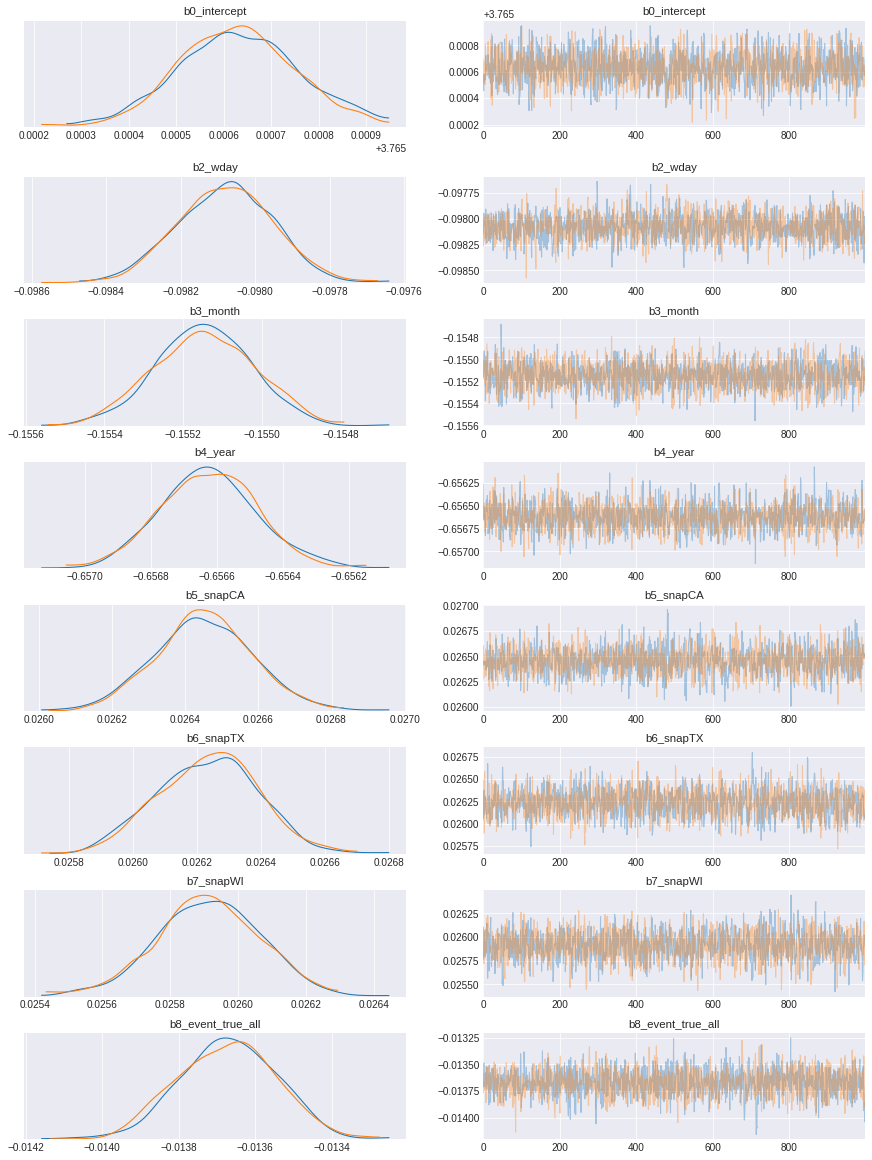

In [34]:
pm.plot_trace(trace)

## Sample posterior predictive parameters

In [35]:
with mdl_first:
    pp_trace = pm.sample_posterior_predictive(trace, var_names=rvs_fish, samples=4000)

100%|██████████| 4000/4000 [00:00<00:00, 8193.90it/s]


## Create submission data set

Here since we only modeled the total sales, we will specifically use test set that indicates the total sale

In [36]:
df_2 = scaled_feature.iloc[1913:,:]
total_id = [i for i in submission.id if 'Total' in i]
# change back d_parse
df_2['d_parse']= calendar_feature.iloc[1913:,:].d_parse.values


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
df_2.d_parse.max()

1969

In [38]:
submission_validation = df_2.iloc[:28, :]
submission_evaluation = df_2.iloc[28:, :]
submission_validation.shape,submission_evaluation.shape

((28, 9), (28, 9))

## Use posterior predictive parameters to estimate the posterior interval of Y (uncertainty)

In [39]:
pp_trace.keys()

dict_keys(['b0_intercept', 'b2_wday', 'b3_month', 'b4_year', 'b5_snapCA', 'b6_snapTX', 'b7_snapWI', 'b8_event_true_all'])

In [40]:
pp_trace['b0_intercept']

array([3.76557402, 3.76545654, 3.7654554 , ..., 3.76564496, 3.76564425,
       3.76564879])

In [41]:
def return_y(df):
    result = 1*pp_trace['b0_intercept']
    for (i,j) in zip([*pp_trace.keys()][1:], df.index[1:]):
        #print(i, j)
        result += pp_trace[i]*df[j]
        #print(result)
    return np.exp(result + np.log(df['d_parse']))
    #return result
validation_y = np.zeros((28, 4000))
evaluation_y = np.zeros((28, 4000))

In [42]:
submission_validation.iloc[0].index

Index(['wm_yr_wk', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'event_true_all', 'd_parse'],
      dtype='object')

In [43]:
#submission_evaluation.iloc[0]

In [44]:
for row in range(len(submission_validation)):
    validation_y[row, :] = return_y(submission_validation.iloc[row])
    evaluation_y[row, :] = return_y(submission_evaluation.iloc[row])

In [45]:
np.mean(validation_y)

29132.330326098054

In [46]:
np.mean(total_historical)

34397.992158912704

In [47]:
## organize the data
total_qt = [float(i.split('_')[2]) for i in total_id]

total_only_submission = submission[submission.id.isin(total_id)]

total_only_submission['qt']=total_qt

total_only_submission.reset_index(inplace=True)

total_only_submission.loc[:7]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,id,F1,F2,F3,F4,F5,F6,F7,F8,...,F20,F21,F22,F23,F24,F25,F26,F27,F28,qt
0,0,Total_X_0.005_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.005
1,42840,Total_X_0.025_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.025
2,85680,Total_X_0.165_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.165
3,128520,Total_X_0.250_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.250
4,171360,Total_X_0.500_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500
5,214200,Total_X_0.750_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.750
6,257040,Total_X_0.835_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.835
7,299880,Total_X_0.975_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.975


In [48]:
for i in range(1,29):
    col_name = 'F' + str(i)
    total_only_submission.loc[:8,col_name] =np.quantile(validation_y[i-1], total_qt[:9])

for i in range(1,29):
    col_name = 'F' + str(i)
    total_only_submission.loc[9:,col_name] =np.quantile(evaluation_y[i-1], total_qt[:9])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
total_only_submission

,index,id,F1,F2,F3,F4,F5,F6,F7,F8,...,F20,F21,F22,F23,F24,F25,F26,F27,F28,qt
0,0,Total_X_0.005_validation,29680.247303,28276.022444,26935.449198,25658.248676,24442.098266,31208.349902,31773.489341,31808.857120,...,33371.189530,33622.888269,28673.343203,27316.497712,26021.864152,24788.285770,23612.274898,31704.844705,30206.520433,0.005
1,42840,Total_X_0.025_validation,29685.607194,28279.854087,26940.692466,25664.347448,24447.644111,31220.897478,31786.323021,31816.271651,...,33380.646096,33629.436963,28678.841286,27320.539921,26026.602158,24793.638623,23618.401482,31712.974935,30212.531809,0.025
2,85680,Total_X_0.165_validation,29694.279584,28288.601174,26948.980199,25672.524007,24456.306320,31237.455689,31806.603087,31829.784176,...,33395.425509,33641.355650,28687.418955,27329.080437,26034.696907,24801.329522,23626.312150,31722.542718,30221.474770,0.165
3,128520,Total_X_0.250_validation,29697.061908,28291.177925,26951.499571,25675.016941,24458.889903,31242.636807,31812.366319,31834.449002,...,33399.919450,33645.201425,28689.768594,27331.402963,26036.981394,24803.860068,23628.835900,31725.703414,30224.381135,0.250
4,171360,Total_X_0.500_validation,29703.065755,28296.798337,26956.832852,25680.695563,24464.630226,31254.180197,31825.708331,31843.833916,...,33410.608856,33654.301238,28695.676140,27336.835977,26042.369389,24809.178272,23634.325407,31733.522392,30230.854983,0.500
5,214200,Total_X_0.750_validation,29708.862008,28301.926879,26962.201226,25686.097206,24470.657505,31265.693789,31839.217318,31852.410857,...,33419.756714,33662.833206,28701.067512,27341.841406,26047.328694,24814.627513,23640.147458,31740.805182,30237.061460,0.750
6,257040,Total_X_0.835_validation,29711.437827,28304.451707,26964.911287,25688.798825,24473.356203,31271.280495,31845.136330,31856.397034,...,33424.217997,33666.656479,28703.634054,27344.440439,26049.964934,24816.979571,23642.691971,31743.870868,30239.992154,0.835
7,299880,Total_X_0.975_validation,29719.998789,28312.964504,26973.744204,25697.509345,24482.256991,31286.423754,31860.828892,31869.426595,...,33438.241362,33681.428167,28712.106488,27352.666519,26058.694795,24825.329701,23651.347495,31754.105557,30249.089059,0.975
8,342720,Total_X_0.995_validation,29726.130050,28318.717048,26978.045065,25703.036517,24488.148139,31295.531508,31870.454534,31876.299348,...,33446.208253,33688.626438,28717.973324,27357.807161,26063.087357,24830.664946,23657.058806,31760.806336,30254.302052,0.995
9,385560,Total_X_0.005_evaluation,28777.071060,27415.266041,26115.902897,24877.820342,23697.517768,31819.243629,30315.456879,27462.339330,...,34213.421741,32594.217781,29381.529851,27972.871839,28179.692527,24029.520674,22889.055343,30734.551228,27843.513133,0.005


In [50]:
total_only_submission.to_csv('total_submission.csv', index=False)

## For improvement...

* Adding more features
* Adding different hierachies 
* Better prior: it seems really tricky to update the MCMC chain because the overdispersed prior, I have to tune the prior condition multiple times to get a good convergence
